# Visualisations for PyTorch quickstart tutorial

In [2]:
# DO NOT REMOVE: imports for loading job outputs & config
# for loading data
from pathlib import Path
import pickle

# for loading the correct config
import importlib.util
import sys


In [3]:
# Imports for your code
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np

from code.train import NeuralNetwork
from code.train import testing_step

/data/coml-hawkes/lady6235/.conda/envs/numpyro10_torch_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Set current JOB id here
slurm_id = 1556973

# get specifically the arguments used for training (this is somewhat messy, but it does ensure that exactly the correct arguments are imported)
spec = importlib.util.spec_from_file_location("config", "outputs/{}/output/config.py".format(slurm_id))
config_module = importlib.util.module_from_spec(spec)
sys.modules["config"] = config_module
spec.loader.exec_module(config_module)
args = config_module.args

In [5]:
# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

## Load 

In [6]:


# Create data loaders.
test_dataloader = DataLoader(test_data, batch_size=args["batch_size"])

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


## Load model and test prediction

In [8]:
# includes any model structure in the saving - requires the model class to be imported
model =torch.load(f"outputs/{slurm_id}/output/model.pth", map_location=torch.device('cpu'))

In [9]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


In [11]:
testing_step(test_dataloader, model, args["loss_fn"], "cpu")

Test Error: 
 Accuracy: 70.3%, Avg loss: 0.789179 



0.7891785665682167

## Graph losses in training

10


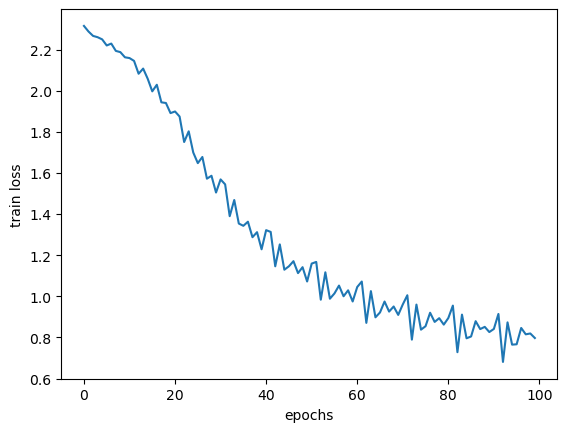

In [12]:
train_loss_list = pickle.loads(Path("outputs", str(slurm_id), "output/train_loss_list").read_bytes())
print(len(train_loss_list))
flattened = [num for elem in train_loss_list for num in elem]
plt.figure()
plt.plot(np.arange(len(flattened)), flattened, label="train loss")
plt.xlabel("epochs")
plt.ylabel("train loss")
plt.show()

10


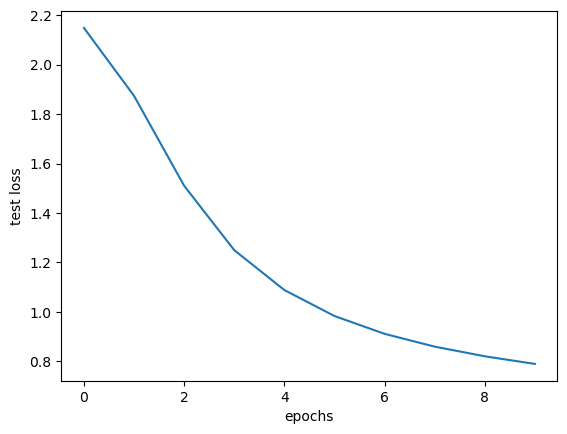

In [13]:
test_loss_list = pickle.loads(Path("outputs", str(slurm_id), "output/test_loss_list").read_bytes())
print(len(test_loss_list))
plt.figure()
plt.plot(np.arange(len(train_loss_list)), test_loss_list, label="testing loss during training")
plt.xlabel("epochs")
plt.ylabel("test loss")
plt.show()